Python 3.10.12
/home/nikto/study/mlops-zoomcamp/02-experiment-tracking


/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


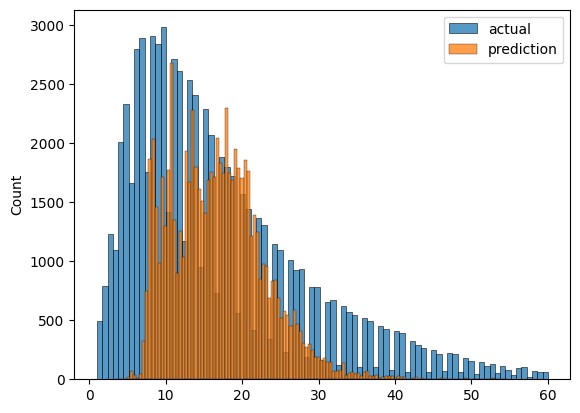

/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1]:
%run "2.2 Getting started with MLflow.ipynb"

The next cell is necessary if you are running this notebook on many machines and sharing database

In [2]:
#check artifacts' path symlink
import os
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    # Extract the artifact location
    artifact_location = experiment.artifact_location

    # Check if it starts with 'file://'
    if artifact_location.startswith("file://"):
       # Extract the filesystem path
        artifact_path = artifact_location[len("file://"):]

        
    else:
        if artifact_location.startswith("/"):
            artifact_path=artifact_location
        else:
            raise Exception(f"Artifact location {artifact_location} is not using local filesystem.")
            # exit(1)
    # Check if the artifact location directory exists
    if os.path.exists(artifact_path):
        print(f"Directory {artifact_path} exists.")
    else:
        windows_command = "mklink /D " + artifact_path.replace('/', '\\') + " C:\\path\\to\\actual\\artifact\\directory"

        raise Exception(f"Directory {artifact_path} does not exist. Create it with: On Linux/macOS: `ln -s /path/to/actual/artifact/directory {artifact_path}`, On Windows: `{windows_command}`")
        # exit(1)
else:
    raise Exception(f"No experiment with name '{experiment_name}'.")
    # exit(1)

Directory /workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2 exists.


In [3]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


In [4]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), #exp(-3), exp(0) - [.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

mlflow.xgboost.autolog(disable=True)

In [5]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.3739384855552223,
        'max_depth': 77,
        'min_child_weight': 1.1615610516606711,
        'objective': 'reg:linear',
        'reg_alpha': 0.023237596270245534,
        'reg_lambda': 0.36048716808073483,
        'seed': 42,
        'tree_method':'hist',
        'device':'cuda'
    }
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.32695
[1]	validation-rmse:7.84625
[2]	validation-rmse:7.13690
[3]	validation-rmse:6.79844
[4]	validation-rmse:6.63328
[5]	validation-rmse:6.54705
[6]	validation-rmse:6.49953
[7]	validation-rmse:6.46946
[8]	validation-rmse:6.45098
[9]	validation-rmse:6.43562
[10]	validation-rmse:6.42734
[11]	validation-rmse:6.42141
[12]	validation-rmse:6.41812
[13]	validation-rmse:6.41518
[14]	validation-rmse:6.41165
[15]	validation-rmse:6.40858
[16]	validation-rmse:6.40448
[17]	validation-rmse:6.40193
[18]	validation-rmse:6.39725
[19]	validation-rmse:6.39536
[20]	validation-rmse:6.39143
[21]	validation-rmse:6.38871
[22]	validation-rmse:6.38503
[23]	validation-rmse:6.38209
[24]	validation-rmse:6.38057
[25]	validation-rmse:6.37853
[26]	validation-rmse:6.37728
[27]	validation-rmse:6.37542
[28]	validation-rmse:6.37402
[29]	validation-rmse:6.37192
[30]	validation-rmse:6.37013
[31]	validation-rmse:6.36874
[32]	validation-rmse:6.36757
[33]	validation-rmse:6.36566
[34]	validation-rmse:6.3

/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        